In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rice_ml.supervised_learning import LogisticRegressionGD

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (6, 4)


In [7]:
#Get processed data from Notebook 1
df = pd.read_csv("../data/lesions_processed.csv")
df.head()


,x_norm,y_norm,slice_norm,r_xy,quad_x,quad_y,experiment,tampered,type,uuid,slice,x,y
0,0.678571,0.945409,0.198413,499.489740,1,1,1,1,FB,1280,100,323,381
1,0.743697,0.714640,0.150794,456.355125,1,1,1,1,FB,1009,76,354,288
2,0.342437,0.473945,0.156746,251.097591,0,0,1,1,FB,7794,79,163,191
3,0.710084,0.602978,0.186508,416.284758,1,1,1,1,FB,7794,94,338,243
4,0.327731,0.334988,0.089286,206.303175,0,0,1,1,FB,2997,45,156,135


In [9]:
#Feature Matrix
feature_cols = [
    "x_norm",
    "y_norm",
    "slice_norm",
    "r_xy",
    "quad_x",
    "quad_y",
    "experiment",
]

target_col = "tampered"

X = df[feature_cols].values
y = df[target_col].values.astype(int)

X.shape, y.shape


((169, 7), (169,))

In [10]:
#Train
rng = np.random.default_rng(42)

indices = np.arange(len(X))
rng.shuffle(indices)

test_size = int(0.2 * len(X))

test_idx = indices[:test_size]
train_idx = indices[test_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train.shape, X_test.shape


((136, 7), (33, 7))

In [19]:
#Standardize features from training
mean_ = X_train.mean(axis=0)
std_ = X_train.std(axis=0)
std_[std_ == 0] = 1.0  # avoid zero division

X_train_scaled = (X_train - mean_) / std_
X_test_scaled = (X_test - mean_) / std_

#Check results
X_train_scaled.mean(axis=0), X_train_scaled.std(axis=0)



(array([-2.97352012e-16, -7.87768543e-16,  4.77559169e-17, -9.64914423e-16,
         1.89390987e-16,  1.95921710e-17,  2.20411924e-16]),
 array([1., 1., 1., 1., 1., 1., 1.]))

In [13]:
#Train logistic regression model
logreg = LogisticRegressionGD(lr=0.1, n_iters=2000)
logreg.fit(X_train_scaled, y_train)


In [16]:
#Make predictions
y_pred = logreg.predict(X_test_scaled)
#How accurate is it
accuracy = (y_pred == y_test).mean()
print(f"Test accuracy: {accuracy:.3f}")


Test accuracy: 0.758


True 0 or Predicted 1 = false positive 
True 1 or Predicted 0 = false negative

False negatives are dangerous because it means the model misses a tampered lesion. A patient could have a lesion but the model will not show it.

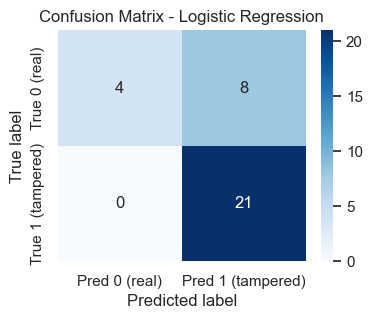

In [18]:
#Confusion Matrix
cm = np.zeros((2, 2), dtype=int)

for yt, yp in zip(y_test, y_pred):
    cm[yt, yp] += 1

cm

#Plot
plt.figure(figsize=(4, 3))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Pred 0 (real)", "Pred 1 (tampered)"],
    yticklabels=["True 0 (real)", "True 1 (tampered)"],
)
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

